In [ ]:
df_with_out.columns

'''
df_with_out[cat_cols] = df_with_out[cat_cols].astype('object')
numerical_with_out = df_with_out.select_dtypes(include=['int64', 'float64'])

local_scaler = StandardScaler()
numerical_scaled_with_out = local_scaler.fit_transform(numerical_with_out)
numerical_scaled_with_out = pd.DataFrame(numerical_scaled_with_out, columns=numerical_with_out.columns)


df_no_out = df_with_out[df_with_out['OUTLIER'] == 0]
df_no_out[cat_cols] = df_no_out[cat_cols].astype('object')
numerical_no_out = df_no_out.select_dtypes(include=['int64', 'float64'])

numerical_scaled_no_out = local_scaler.fit_transform(numerical_no_out)
numerical_scaled_no_out = pd.DataFrame(numerical_scaled_no_out, columns=numerical_no_out.columns)
'''

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import random
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import mapply
mapply.init(n_workers=7, progressbar=True)
import pickle
with open('scaler.pickle', 'rb') as f:
    scaler: StandardScaler = pickle.load(f)

/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [127]:
def prepare_for_clustering(df, remove_outliers=True, with_indicators=True):
    cat_cols = ['date_month', 'date_day', 'date_year', 'congressional_district', 'state',
            'incident_characteristics1', 'city_or_county', 'party', 'CLEAN', 'OUTLIER']

    orig_num_cols = ['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
            'max_age_participants', 'n_participants_child', 'n_participants_teen',
            'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
            'n_arrested', 'n_unharmed', 'n_participants', 'timestamp',
            'povertyPercentage', 'candidatevotes', 'totalvotes']

    if remove_outliers:
        df = df[df['OUTLIER'] == 0]

    df.loc[:, cat_cols] = df.loc[:, cat_cols].astype('object')#df[cat_cols] = df[cat_cols].astype('object')
    numerical_df = df.select_dtypes(include=['int64', 'float64'])

    if not with_indicators:
        numerical_df = numerical_df[orig_num_cols]

    scaler = StandardScaler()
    numerical_scaled = scaler.fit_transform(numerical_df)
    numerical_scaled = pd.DataFrame(numerical_scaled, columns=numerical_df.columns)

    return numerical_scaled


def features_reduction_corr(df, correlation_threshold=0.7):
    # Compute the correlation matrix
    correlation_matrix = df.corr()

    # Identify highly correlated features
    highly_correlated_features = set()

    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
                colname = correlation_matrix.columns[i]
                highly_correlated_features.add(colname)

    # Remove highly correlated features
    df_filtered = df.drop(columns=highly_correlated_features)
    return df_filtered


def features_reduction_var(df, variance_threshold=2):
    # Compute the variance of each feature
    feature_variances = df.var()

    # Identify features below the variance threshold
    low_variance_features = feature_variances[feature_variances < variance_threshold].index

    # Prune (remove) features below the threshold
    df_pruned = df.drop(columns=low_variance_features)

    return df_pruned


def k_means(df, n_samples=1, sample_size=1000, k_min=2, k_max=10, initial_centroids=None, return_models=False):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_df = df[numeric_cols]
    
    modelss = [[], []]
    scoress = [[], []]
    sampless = [[], []]

    for i in range(0, k_max):
        modelss.append([])
        scoress.append([])
        sampless.append([])
        
    for i in range(0, n_samples):
        sample = numeric_df.sample(n=sample_size).copy()
        for k in tqdm(range(k_min, k_max+1)):
            if initial_centroids is None:
                model = KMeans(n_clusters=k, n_init=10)
            else:
                model = KMeans(n_clusters=k, n_init=10, init=initial_centroids)
            labels = model.fit_predict(sample)
            score = silhouette_score(sample, labels)

            if return_models:
                modelss[k].append(model)
                scoress[k].append(score)
                sampless[k].append(sample)

    return modelss, scoress, sampless


def perform_PCA(df, centroids=None, n_components=2):
    pca = PCA(n_components=n_components)

    points_pca = pca.fit_transform(df)
    if centroids is not None:
        centroids_pca = pca.transform(centroids)

    return points_pca, centroids_pca


def find_features(df, columns, col_scores, threshold=0.1):
    prev_max_score = max(col_scores)
    actual_cols = [columns.pop(0)]
    
    for col in columns:
        actual_cols.append(col)
        scores, _, _ = k_means(df=df[actual_cols], n_samples=1, sample_size=10000, k_min=2, k_max=10)
        max_score = max(scores)
        if np.abs(prev_max_score - max_score) > 0.1:#prev_max_score > max_score:
            actual_cols.pop()
            print(col + ' discarded')
            print('actual score: ' + str(max_score))
        else:
            if prev_max_score < max_score:
                prev_max_score = max_score
            print(col + ' added')
            print('actual score: ' + str(max_score))
    return actual_cols, prev_max_score


def order_features(df):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_df = df[numeric_cols]
    columns = numeric_df.columns.tolist()
    #random.shuffle(columns)

    max_scores = []
    for col in columns:
        scores, _, _ = k_means(df=df[[col]], n_samples=1, sample_size=10000, k_min=2, k_max=9)
        max_scores.append(max(scores))

    # Combine items and scores using zip
    combined = list(zip(columns, max_scores))

    # Sort the combined list based on scores in descending order
    sorted_combined = sorted(combined, key=lambda x: x[1], reverse=True)

    # Extract the sorted items
    sorted_cols = [item for item, score in sorted_combined]
    # Extract the sorted scores
    sorted_scores = [score for item, score in sorted_combined]

    return sorted_cols, sorted_scores


def sample_columns(df, num_columns_to_sample=1):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_df = df[numeric_cols]
    df_reduced = numeric_df.sample(n=num_columns_to_sample, axis=1).copy()
    return df_reduced

In [25]:
df = pd.read_csv('./dataset/data/final_clean2.csv')

df_with_out = prepare_for_clustering(df, remove_outliers=False, with_indicators=True)
df_no_out = prepare_for_clustering(df, remove_outliers=True, with_indicators=True)
df_with_out_orig = prepare_for_clustering(df, remove_outliers=False, with_indicators=False)
df_no_out_orig = prepare_for_clustering(df, remove_outliers=True, with_indicators=False)

print(f'Dataset dimentions: {df.shape}')
print(f'Dataset dimentions with ouliers, with only numerical cols, with indicators: {df_with_out.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, with indicators: {df_no_out.shape}')
print(f'Dataset dimentions with ouliers, with only numerical cols, without indicators: {df_with_out_orig.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, without indicators: {df_no_out_orig.shape}')

Dataset dimentions: (235219, 61)
Dataset dimentions with ouliers, with only numerical cols, with indicators: (235219, 51)
Dataset dimentions without ouliers, with only numerical cols, with indicators: (190977, 51)
Dataset dimentions with ouliers, with only numerical cols, without indicators: (235219, 19)
Dataset dimentions without ouliers, with only numerical cols, without indicators: (190977, 19)


## Experiments on the not augmented dataset:

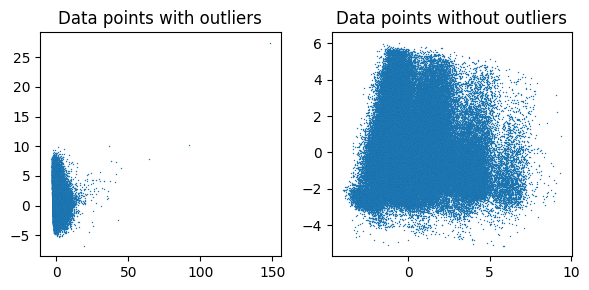

In [73]:
pca_with_out = perform_PCA(df=df_with_out_orig, n_components=2)
pca_no_out = perform_PCA(df=df_no_out_orig, n_components=2)


plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.scatter(pca_with_out.iloc[:, 0], pca_with_out.iloc[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Data points with outliers')

plt.subplot(1, 2, 2)
plt.scatter(pca_no_out.iloc[:, 0], pca_no_out.iloc[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Data points without outliers')

plt.tight_layout()
plt.show()

#### K-means on the full (not augmented) dataset with outliers

In [105]:
k_min = 2
k_max = 10

modelss, scoress, sampless = k_means(df_with_out_orig, n_samples=10, sample_size=10000, k_min=k_min, k_max=k_max, return_models=True)

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:27<00:00,  3.02s/it]


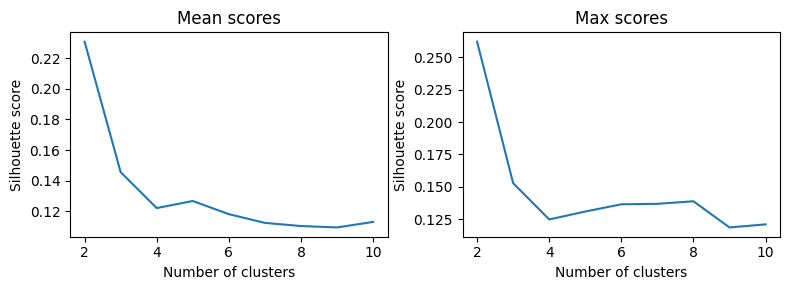

Max score: 0.2622116639511403 (for k=2)


In [106]:
mean_scores = []
for k in range(k_min, k_max+1):
    mean_scores.append(np.mean(np.array(scoress[k])))

max_scores = []
for k in range(k_min, k_max+1):
    max_scores.append(np.max(np.array(scoress[k])))

k_values = np.arange(k_min, k_max+1)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

axes[0].plot(k_values, mean_scores)
axes[0].set_title('Mean scores')
axes[0].set_xlabel('Number of clusters')
axes[0].set_ylabel('Silhouette score')

axes[1].plot(k_values, max_scores)
axes[1].set_title('Max scores')
axes[1].set_xlabel('Number of clusters')
axes[1].set_ylabel('Silhouette score')

plt.tight_layout()
plt.show()

print(f'Max score: {np.max(max_scores)} (for k={np.argmax(max_scores)+k_min})')

In [111]:
# Too much time to compute the silouette score on the entire dataset -> sampling

best_k = np.argmax(max_scores)+k_min

best_model_index = np.argmax(scoress[best_k]).astype(np.int64)
best_model = modelss[best_k][best_model_index]

sample = df_with_out_orig.sample(n=50000).copy()

labels = best_model.predict(sample)
score = silhouette_score(sample, labels)

print(f'Best model score: {score}')

Best model score: 0.2594527296555502


In [117]:
k = mean_scores.index(max(mean_scores)) + k_min

modelss, scoress, sampless = k_means(df_with_out_orig, n_samples=4, sample_size=50000, k_min=k, k_max=k, return_models=True)
print(f'Best score: {np.max(scoress[k])}')

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:43<00:00, 43.83s/it]

0.25961641552114567


/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


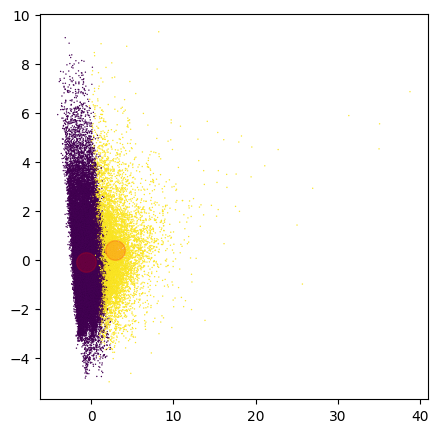

In [129]:
best_model_index = np.argmax(scoress[best_k]).astype(np.int64)
best_model = modelss[best_k][best_model_index]
best_model_samples = sampless[k][best_model_index]

points_pca, centroids_pca = perform_PCA(df=best_model_samples, centroids=best_model.cluster_centers_, n_components=2)

plt.figure(figsize=(5, 5))
plt.scatter(points_pca[:, 0], points_pca[:, 1], c=best_model.labels_, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', s=200, alpha=0.2)
plt.show()

#### Feature reduction using variance

In [18]:
reduced_with_out_orig_var = features_reduction_var(df_with_out_orig, variance_threshold=1)
reduced_no_out_orig_var = features_reduction_var(df_no_out_orig, variance_threshold=1)
print('Survived columns (with outliers):----------------------------------------------')
print(f'n_cols = {len(reduced_with_out_orig_var.columns)}')
print(reduced_with_out_orig_var.columns)
print('\nSurvived columns (without outliers):----------------------------------------------')
print(f'n_cols = {len(reduced_no_out_orig_var.columns)}')
print(reduced_no_out_orig_var.columns)

Survived columns (with outliers):----------------------------------------------
n_cols = 18
Index(['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_participants_teen', 'n_participants_adult',
       'n_males', 'n_females', 'n_killed', 'n_injured', 'n_arrested',
       'n_unharmed', 'n_participants', 'timestamp', 'povertyPercentage',
       'candidatevotes', 'totalvotes'],
      dtype='object')

Survived columns (without outliers):----------------------------------------------
n_cols = 19
Index(['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_participants_child', 'n_participants_teen',
       'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed', 'n_participants', 'timestamp',
       'povertyPercentage', 'candidatevotes', 'totalvotes'],
      dtype='object')


#### Feature reduction using correlation

In [19]:
reduced_with_out_orig = features_reduction_corr(reduced_with_out_orig_var, correlation_threshold=0.3)
reduced_no_out_orig = features_reduction_corr(reduced_no_out_orig_var, correlation_threshold=0.3)
print('Survived columns (with outliers):----------------------------------------------')
print(f'n_cols = {len(reduced_with_out_orig.columns)}')
print(reduced_with_out_orig.columns)
print('\nSurvived columns (without outliers):----------------------------------------------')
print(f'n_cols = {len(reduced_no_out_orig.columns)}')
print(reduced_no_out_orig.columns)

Survived columns (with outliers):----------------------------------------------
n_cols = 7
Index(['latitude', 'longitude', 'min_age_participants', 'n_participants_teen',
       'n_females', 'n_killed', 'timestamp'],
      dtype='object')

Survived columns (without outliers):----------------------------------------------
n_cols = 9
Index(['latitude', 'longitude', 'min_age_participants', 'n_participants_child',
       'n_participants_teen', 'n_participants_adult', 'n_killed', 'n_injured',
       'timestamp'],
      dtype='object')


#### K-means on the reduced (not augmented) dataset with outliers

#### K-means on the reduced dataset with outliers

In [ ]:
k_min = 2
k_max = 10

scores, models, samples = k_means(numerical_scaled, n_samples=10, sample_size=10000, k_min=k_min, k_max=k_max, return_models=True)

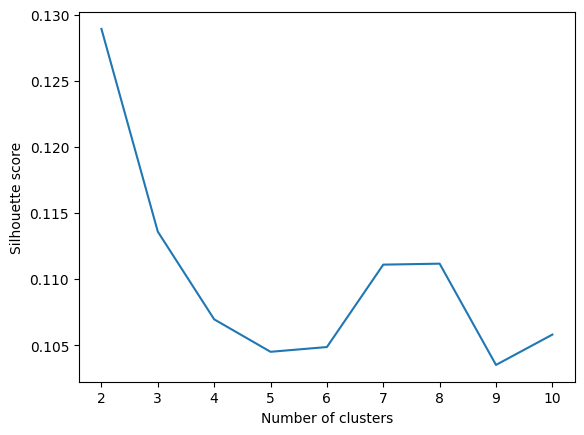

In [10]:
k_min = 2
k_max = 10

plt.plot(range(k_min, k_max+1), scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

In [ ]:
k_min = 2
k_max = 2

scores, models, samples = k_means(numerical_scaled, n_samples=10, sample_size=20000, k_min=k_min, k_max=k_max, return_models=True)
print(scores)

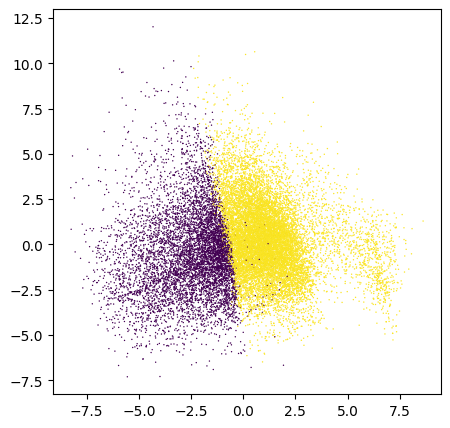

In [20]:
k = 2
i = 0

df_pca = perform_PCA(df=samples[k][i], n_components=5)

plt.figure(figsize=(5, 5))
plt.scatter(df_pca.iloc[:, 0], df_pca.iloc[:, 1], c=models[k][i].labels_, s=1, edgecolors='black', linewidths=0.001)
plt.show()

In [85]:
k_min = 2
k_max = 10 

scores, models, samples = k_means(numerical_r, n_samples=10, sample_size=10000, k_min=k_min, k_max=k_max, return_models=True)

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:24<00:00,  2.76s/it]


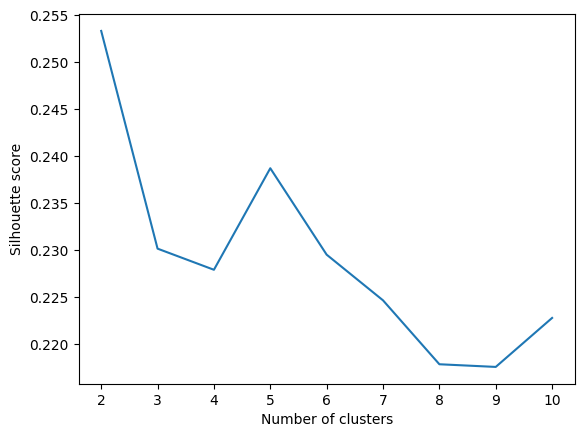

In [86]:
k_min = 2
k_max = 10

plt.plot(range(k_min, k_max+1), scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

In [87]:
k_min = 2
k_max = 2

scores, models, samples = k_means(numerical_r, n_samples=10, sample_size=20000, k_min=k_min, k_max=k_max, return_models=True)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:07<00:00,  7.56s/it]


[0.3252329224890786]


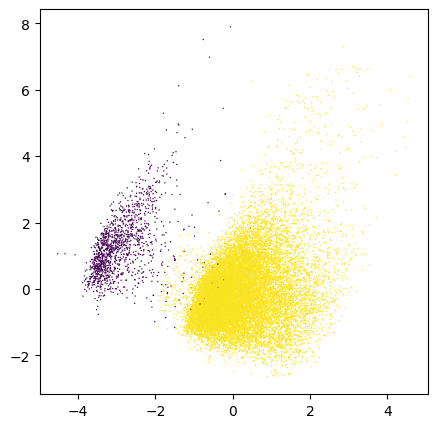

In [94]:
print(scores)

k = 2
i = 0

df_pca = perform_PCA(df=samples[k][i], n_components=5)

plt.figure(figsize=(5, 5))
plt.scatter(df_pca.iloc[:, 0], df_pca.iloc[:, 1], c=models[k][i].labels_, s=1, edgecolors='black', linewidths=0.001)
plt.show()

In [136]:
numerical_r2 = features_reduction_corr(numerical_rv, correlation_threshold=0.05)
numerical_r2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190977 entries, 0 to 190976
Data columns (total 3 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   latitude              190977 non-null  float64
 1   longitude             190977 non-null  float64
 2   min_age_participants  190977 non-null  float64
dtypes: float64(3)
memory usage: 4.4 MB


In [137]:
k_min = 2
k_max = 10 

scores, models, samples = k_means(numerical_r2, n_samples=10, sample_size=10000, k_min=k_min, k_max=k_max, return_models=True)

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:24<00:00,  2.69s/it]


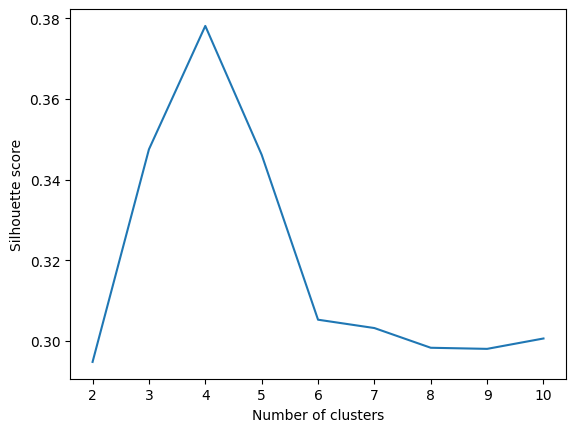

In [138]:
k_min = 2
k_max = 10

plt.plot(range(k_min, k_max+1), scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

In [139]:
k_min = 4
k_max = 4

scores, models, samples = k_means(numerical_r2, n_samples=10, sample_size=20000, k_min=k_min, k_max=k_max, return_models=True)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:06<00:00,  6.72s/it]


[0.3789348528625641]


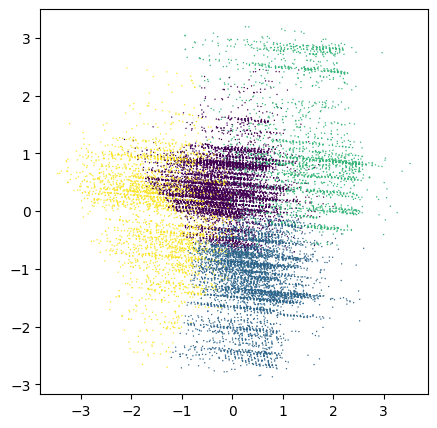

In [144]:
print(scores)

k = 4
i = 0

df_pca = perform_PCA(df=samples[k][i], n_components=3)

plt.figure(figsize=(5, 5))
plt.scatter(df_pca.iloc[:, 2], df_pca.iloc[:, 1], c=models[k][i].labels_, s=1, edgecolors='black', linewidths=0.001)
plt.show()

In [52]:
k_min = 2
k_max = 10 

scores, models, samples = k_means(numerical_r[sorted_cols[0:4]], n_samples=10, sample_size=10000, k_min=k_min, k_max=k_max, return_models=True)

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:22<00:00,  2.51s/it]


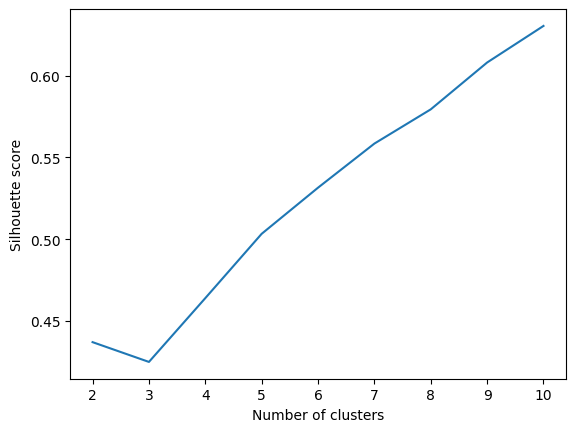

In [53]:
k_min = 2
k_max = 10

plt.plot(range(k_min, k_max+1), scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

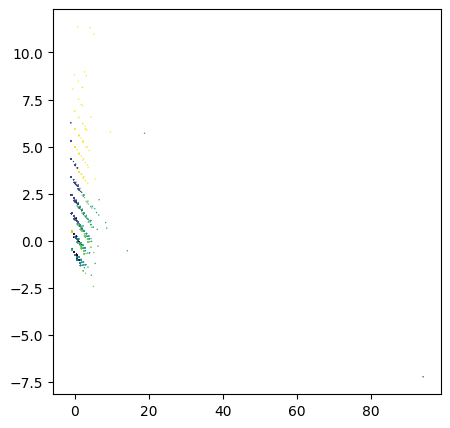

In [55]:
k = 10
i = 0

df_pca = perform_PCA(df=samples[k][i], n_components=2)

plt.figure(figsize=(5, 5))
plt.scatter(df_pca.iloc[:, 0], df_pca.iloc[:, 1], c=models[k][i].labels_, s=1, edgecolors='black', linewidths=0.001)
plt.show()

In [11]:
k_min = 2
k_max = 10 

scores, models, samples = k_means(numerical_scaled, n_samples=10, sample_size=10000, k_min=k_min, k_max=k_max, return_models=True)

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:27<00:00,  3.06s/it]


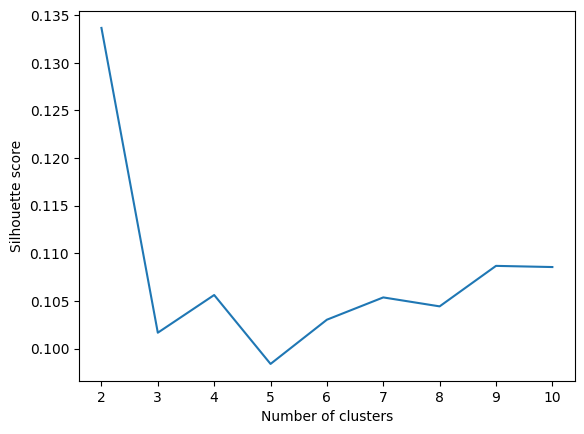

In [12]:
k_min = 2
k_max = 10

plt.plot(range(k_min, k_max+1), scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

In [86]:
def mean_variance_across_clusters(df, model):
    labels = model.labels_
    cluster_variances = []

    for cluster_label in np.unique(labels):
        # Select data points belonging to the current cluster
        cluster_data = df[labels == cluster_label]

        # Compute variance for each feature within the cluster
        feature_variances = np.var(cluster_data, axis=0)

        # Append the feature variances to the list
        cluster_variances.append(feature_variances)

    # Step 4: Calculate the mean variance of each feature across all clusters
    mean_variances = np.mean(cluster_variances, axis=0)

    return mean_variances

In [87]:
mean_variances = mean_variance_across_clusters(samples[2][0], models[2][0])

columns = numerical_scaled.columns.tolist()
# Combine items and scores using zip
combined = list(zip(columns, mean_variances))

# Sort the combined list based on scores in increasing order
sorted_combined = sorted(combined, key=lambda x: x[1], reverse=False)

# Extract the sorted items
sorted_cols = [item for item, score in sorted_combined]

print(mean_variances)

[1.00158996 0.96603838 0.73150172 0.75541443 0.87069761 4.60896476
 1.75130035 1.00556686 1.20466489 1.42933781 0.99581088 1.37708429
 1.32231665 1.13606847 1.3017343  1.02316096 0.97544591 0.99105535
 0.99691799 0.97466678 1.07124315 1.07124315 4.47603073 1.28261387
 0.60697487 0.88696007 0.99871164 0.98854818 0.92957022 0.77477377
 0.80447336 0.91013967 1.14399049 1.12045428 4.47376345 2.09480802
 0.88303798 1.0710379  0.94517654 1.23149591 0.95268594 0.94493522
 1.09339803 1.00627813 0.98944593 0.98944593 1.02226259 1.04281079
 0.98258769 1.00245439]


In [88]:
sorted_cols

['p_participants_adult',
 'min_age_participants',
 'avg_age_participants',
 'month_cd_change_min_age_participants',
 'month_cd_change_avg_age_participants',
 'max_age_participants',
 'month_cd_ratio_participants_adult',
 'p_killed',
 'month_cd_change_max_age_participants',
 'p_unharmed',
 'month_cd_incidents',
 'month_cd_ratio_injured',
 'month_cd_ratio_unharmed',
 'longitude',
 'state_population',
 'povertyPercentage',
 'cd_month_NON_SHOOTING',
 'p_arrested',
 'percentage_republican',
 'percentage_democrat',
 'candidatevotes',
 'n_killed',
 'totalvotes',
 'p_injured',
 'latitude',
 'cd_month_OTHER',
 'n_participants_adult',
 'cd_population',
 'cd_month_SHOT_INJURED',
 'timestamp',
 'cd_month_SHOT_DEAD',
 'month_cd_ratio_killed',
 'p_females',
 'p_males',
 'month_cd_votes_incidents',
 'month_cd_ratio_females',
 'n_unharmed',
 'month_cd_ratio_males',
 'n_males',
 'month_cd_ratio_arrested',
 'p_participants_teen',
 'n_participants',
 'n_arrested',
 'n_injured',
 'n_females',
 'n_particip

In [89]:
k_min = 2
k_max = 10 

scores, models, samples = k_means(numerical_scaled[sorted_cols[0:5]], n_samples=10, sample_size=10000, k_min=k_min, k_max=k_max, return_models=True)

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:21<00:00,  2.37s/it]


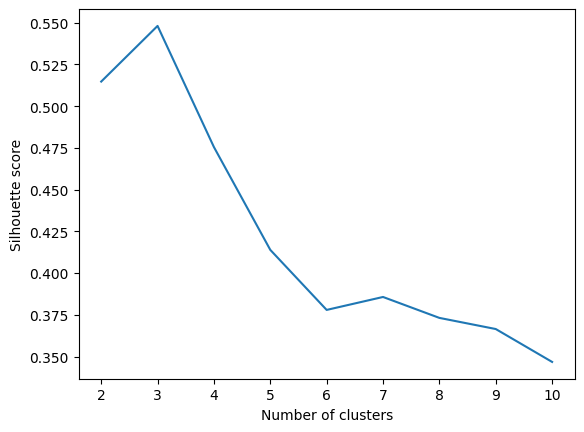

In [90]:
k_min = 2
k_max = 10

plt.plot(range(k_min, k_max+1), scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

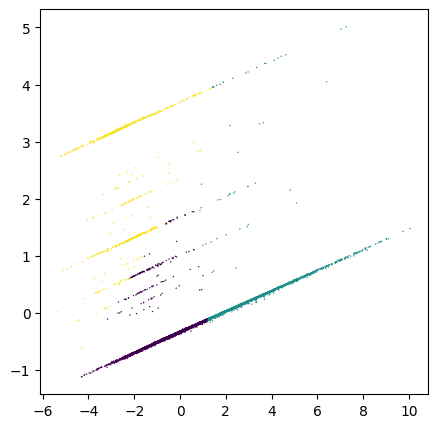

In [107]:
k = 3
i = 0

df_pca = perform_PCA(df=samples[k][i], n_components=5)

plt.figure(figsize=(5, 5))
plt.scatter(df_pca.iloc[:, 0], df_pca.iloc[:, 1], c=models[k][i].labels_, s=1, edgecolors='black', linewidths=0.001)
plt.show()